In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [36]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from evalys import visu
from evalys.jobset import JobSet

In [37]:
input_location = 'KTH-io-aware'
files_prefix = ''
# schedule_names = ['filler', 'backfill-1', 'backfill-sjf-1', 'maxutil-1', 'maxsort-1', 'balance-12-ratio-1', 'balance-11-largest-1', 'balance-12-smallest-1']
schedule_names = ['filler', 'backfill-1', 'backfill-sjf-1', 'maxutil-15-1', 'maxutil-comp-2-2-1', 'maxutil-comp-5-5-1', 'plan-1', 'plan-0']

In [38]:
schedule_files = []
jobs_files = []
for file in os.listdir('../output/' + input_location):
    if file.endswith('_schedule.csv'):
        schedule_files.append(file)
    elif file.endswith('_jobs.csv'):
        jobs_files.append(file)

schedule_files = [os.path.join('../output', input_location, str(file)) for file in sorted(schedule_files)]
jobs_files = [os.path.join('../output', input_location, str(file)) for file in sorted(jobs_files)]
print(schedule_files)
print(jobs_files)

['../output/KTH-io-aware/backfill-1_schedule.csv', '../output/KTH-io-aware/backfill-sjf-1_schedule.csv', '../output/KTH-io-aware/balance-08-largest-1_schedule.csv', '../output/KTH-io-aware/balance-08-ratio-1_schedule.csv', '../output/KTH-io-aware/balance-08-smallest-1_schedule.csv', '../output/KTH-io-aware/balance-09-largest-1_schedule.csv', '../output/KTH-io-aware/balance-09-ratio-1_schedule.csv', '../output/KTH-io-aware/balance-09-smallest-1_schedule.csv', '../output/KTH-io-aware/balance-10-largest-1_schedule.csv', '../output/KTH-io-aware/balance-10-ratio-1_schedule.csv', '../output/KTH-io-aware/balance-10-smallest-1_schedule.csv', '../output/KTH-io-aware/balance-11-largest-1_schedule.csv', '../output/KTH-io-aware/balance-11-ratio-1_schedule.csv', '../output/KTH-io-aware/balance-11-smallest-1_schedule.csv', '../output/KTH-io-aware/balance-12-largest-1_schedule.csv', '../output/KTH-io-aware/balance-12-ratio-1_schedule.csv', '../output/KTH-io-aware/balance-12-smallest-1_schedule.csv', 

In [39]:
metrics = pd.DataFrame()
for file in schedule_files:
    if files_prefix:
        workload_name, schedule_name, _ = os.path.basename(file).split('_')
    else:
        workload_name = ''
        schedule_name, _ = os.path.basename(file).split('_')
    if workload_name != files_prefix:
        continue
    if schedule_name in schedule_names:
        print(workload_name, schedule_name)
        df = pd.read_csv(file)
        df['schedule'] = schedule_name
        metrics = metrics.append(df)
metrics.set_index('schedule', inplace=True)

 backfill-1
 backfill-sjf-1
 filler
 maxutil-15-1
 maxutil-comp-2-2-1
 maxutil-comp-5-5-1
 plan-0
 plan-1


In [40]:
jobsets = {}
for file in jobs_files:
    if files_prefix:
        workload_name, schedule_name, _ = os.path.basename(file).split('_')
    else:
        workload_name = ''
        schedule_name, _ = os.path.basename(file).split('_')
    if workload_name != files_prefix:
        continue
    if schedule_name in schedule_names:
        print(workload_name, schedule_name)
        jobsets[schedule_name] = JobSet.from_csv(file)

 backfill-1
 backfill-sjf-1
 filler
 maxutil-15-1
 maxutil-comp-2-2-1
 maxutil-comp-5-5-1
 plan-0
 plan-1


In [41]:
def transform_jobset(schedule):
    df = jobsets[schedule].df
    static_jobs = df[df.final_state == 'REJECTED'].set_index('jobID')
    dynamic_jobs = df[df.final_state != 'REJECTED']
    times = dynamic_jobs.groupby('workload_name').agg({'success': 'min', 'final_state': 'max', 'starting_time': 'min', 'finish_time':'max'}).reset_index()
    times['jobID'] = times.workload_name.apply(lambda s: s.split('%')[1])
    times.set_index('jobID', inplace=True)
    times.drop('workload_name', axis=1, inplace=True)
    static_jobs = static_jobs.loc[times.index].drop(['success', 'final_state', 'starting_time', 'finish_time'], axis=1).join(times)
    # If job timeout in the stage-in phase then allocated_resources and proc_alloc will be NaN
    resources = dynamic_jobs[dynamic_jobs.profile == 'parallel_homogeneous_profile_0'].groupby('workload_name').agg({'allocated_resources': 'first','proc_alloc': 'first'}).reset_index()
    resources['jobID'] = resources.workload_name.apply(lambda s: s.split('%')[1])
    resources.set_index('jobID', inplace=True)
    resources.drop('workload_name', axis=1, inplace=True)
    static_jobs = static_jobs.drop(['allocated_resources', 'proc_alloc'], axis=1).join(resources)
    static_jobs['execution_time'] = static_jobs.finish_time - static_jobs.starting_time
    static_jobs['waiting_time'] = static_jobs.starting_time - static_jobs.submission_time
    static_jobs['turnaround_time'] = static_jobs.finish_time - static_jobs.submission_time
    static_jobs['stretch'] = static_jobs.turnaround_time / static_jobs.execution_time
    static_jobs.reset_index(inplace=True)
    return static_jobs

In [42]:
for schedule in schedule_names:
    jobsets[schedule].df = transform_jobset(schedule)

In [43]:
def calculate_compute_utilisation(schedule):
    compute_time = jobsets[schedule].df[['execution_time', 'requested_number_of_resources']].apply(lambda row: row.execution_time * row.requested_number_of_resources, axis=1).sum()
    return compute_time / (metrics.loc[schedule].makespan * 96)

def calculate_storage_utilisation(schedule):
    storage_time = jobsets[schedule].df[['execution_time', 'metadata']].apply(lambda row: row.execution_time * row.metadata, axis=1).sum()
    burst_buffer_capacity = 5 * 10**9
    num_burst_buffers = 12
    total_storage_time = metrics.loc[schedule].makespan * num_burst_buffers * burst_buffer_capacity
    return storage_time / total_storage_time

def create_metric_df(metric):
    return pd.concat([jobsets[schedule].df[metric].rename(schedule) for schedule in schedule_names], axis=1)

In [44]:
def bounded_slowdown(df):
    return (df.turnaround_time / df.execution_time.clip(lower=60)).clip(lower=1)

def create_all_metrics_df():
    dfs = []
    for schedule in schedule_names:
        df = jobsets[schedule].df
        df = df.assign(schedule=schedule).assign(bounded_slowdown=bounded_slowdown(df))[['schedule', 'waiting_time', 'turnaround_time', 'stretch', 'bounded_slowdown']]
        dfs.append(df)
    return pd.concat(dfs, axis=0)

In [45]:
metrics['compute_utilisation'] = pd.Series({schedule: calculate_compute_utilisation(schedule) for schedule in schedule_names})
metrics['storage_utilisation'] = pd.Series({schedule: calculate_storage_utilisation(schedule) for schedule in schedule_names})

In [46]:
metrics = metrics.reindex(schedule_names)
metrics.index.rename(None, inplace=True)
sns.set_theme(context='talk', style='whitegrid')
# sns.set_theme(style='whitegrid')

In [47]:
metrics.T

,filler,backfill-1,backfill-sjf-1,maxutil-15-1,maxutil-comp-2-2-1,maxutil-comp-5-5-1,plan-1,plan-0
batsim_version,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0
consumed_joules,0,0,0,0,0,0,0,0
makespan,2.88581e+07,2.88019e+07,2.88154e+07,2.88094e+07,2.88153e+07,2.87969e+07,2.88163e+07,3.01508e+07
max_slowdown,1.00023,1.00024,1.00024,1.00024,1.00024,1.00023,1.00024,1.00024
max_turnaround_time,22655.2,22655.2,22655.2,22655.2,22655.2,22655.2,22655.2,22655.2
max_waiting_time,1e-06,1e-06,1e-06,1e-06,1e-06,1e-06,1e-06,1e-06
mean_slowdown,0.975925,0.975917,0.975919,0.975915,0.97592,0.975918,0.975917,0.975921
mean_turnaround_time,223.303,223.766,223.715,223.84,223.79,223.77,223.821,223.856
mean_waiting_time,0,0,0,0,0,0,0,0
nb_computing_machines,109,109,109,109,109,109,109,109


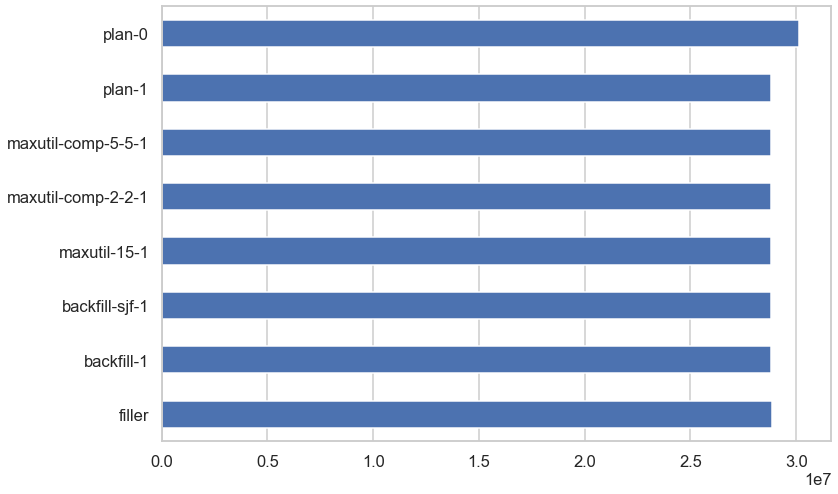

In [48]:
ax = metrics['makespan'].plot.barh(figsize=(12, 8))
ax.grid(axis='y')

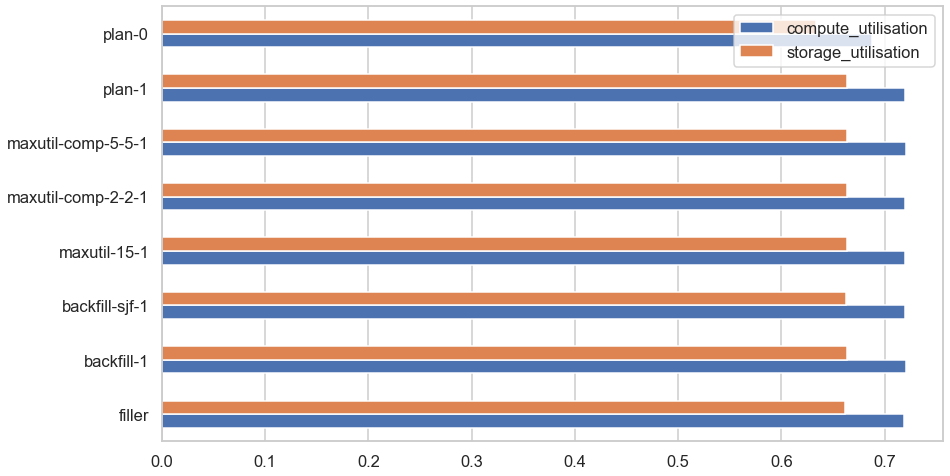

In [49]:
ax = metrics[['compute_utilisation', 'storage_utilisation']].plot.barh(figsize=(14, 8))
ax.grid(axis='y')

In [50]:
metrics_df = create_all_metrics_df()

In [51]:
waiting_times = create_metric_df('waiting_time')
waiting_times.describe()

,filler,backfill-1,backfill-sjf-1,maxutil-15-1,maxutil-comp-2-2-1,maxutil-comp-5-5-1,plan-1,plan-0
count,2.845300e+04,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000,2.845300e+04
mean,2.125873e+04,14554.136424,13917.227718,13955.534028,13950.510986,14092.206716,15481.002152,2.444922e+04
std,1.508317e+05,40463.245257,42628.488380,43980.021576,43134.923738,41440.319607,47399.339471,3.812315e+05
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,0.000000e+00,82.648256,0.000000,0.000002,55.005932,35.591176,67.032005,0.000000e+00
75%,5.005819e+03,9469.730070,6470.368973,6643.460452,7486.448951,8209.282006,7591.687481,7.123000e+03
max,4.991701e+06,639435.911771,634988.117097,641766.146188,721145.154616,626999.902204,618087.468883,2.713930e+07


(0.0, 1000000.0)

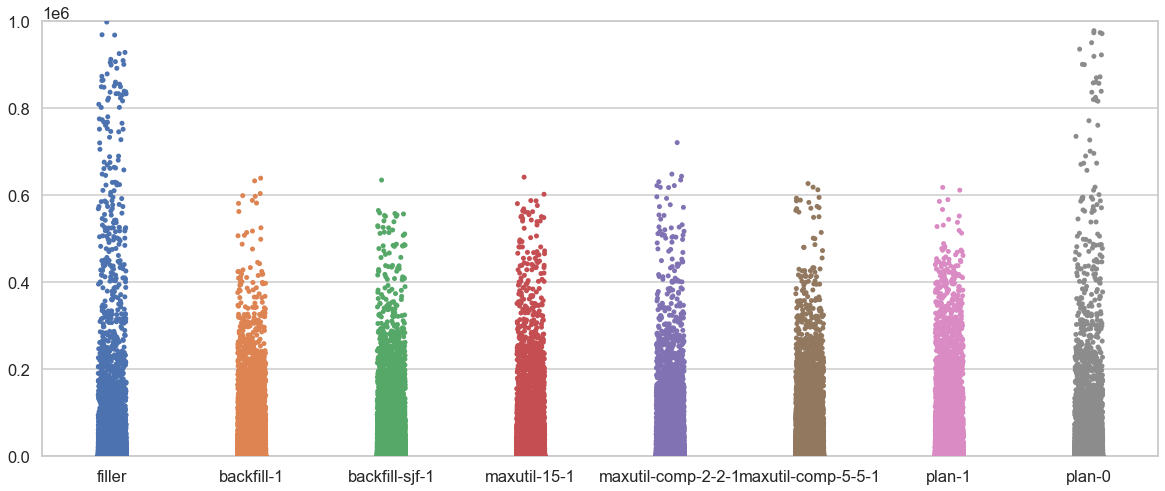

In [52]:
# Scatterplot, outliers
fig, ax = plt.subplots(figsize=(20,8))
sns.stripplot(data=waiting_times, ax=ax)
ax.set_ylim(0, 10**6)

<AxesSubplot:>

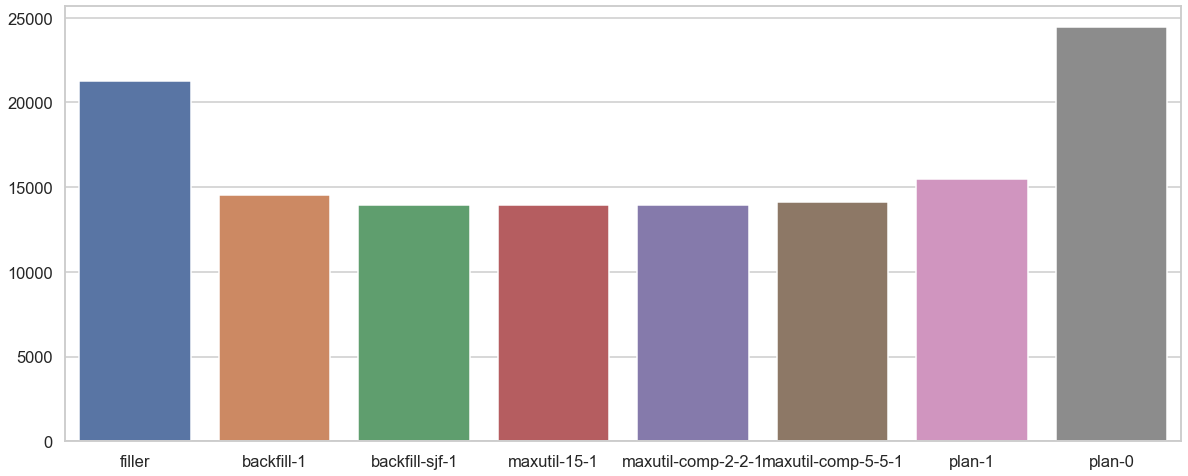

In [53]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data=waiting_times, ci=None, ax=ax)

<AxesSubplot:>

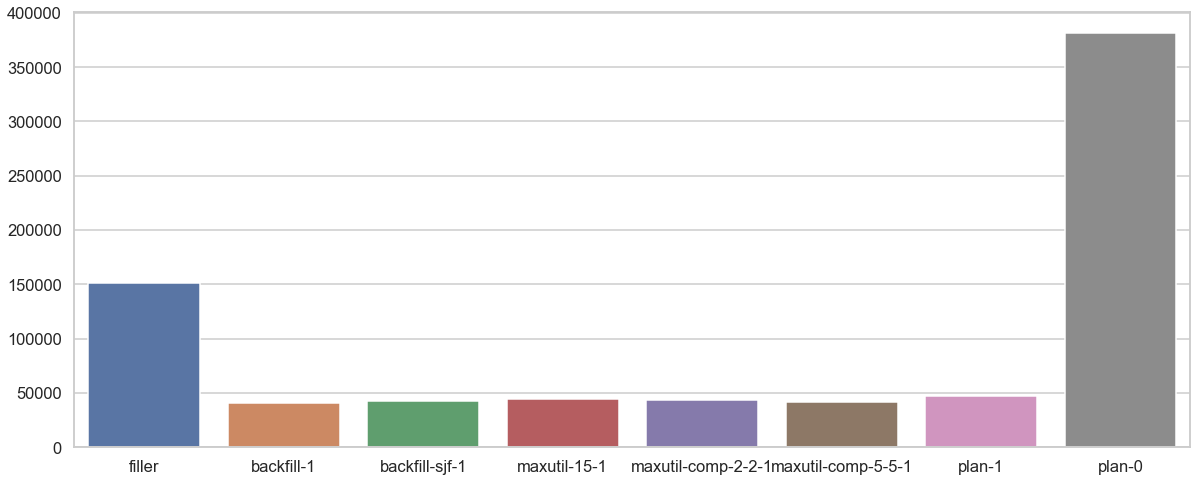

In [54]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data=waiting_times, estimator=np.std, ci=None, ax=ax)

(0.0, 24851.093572198974)

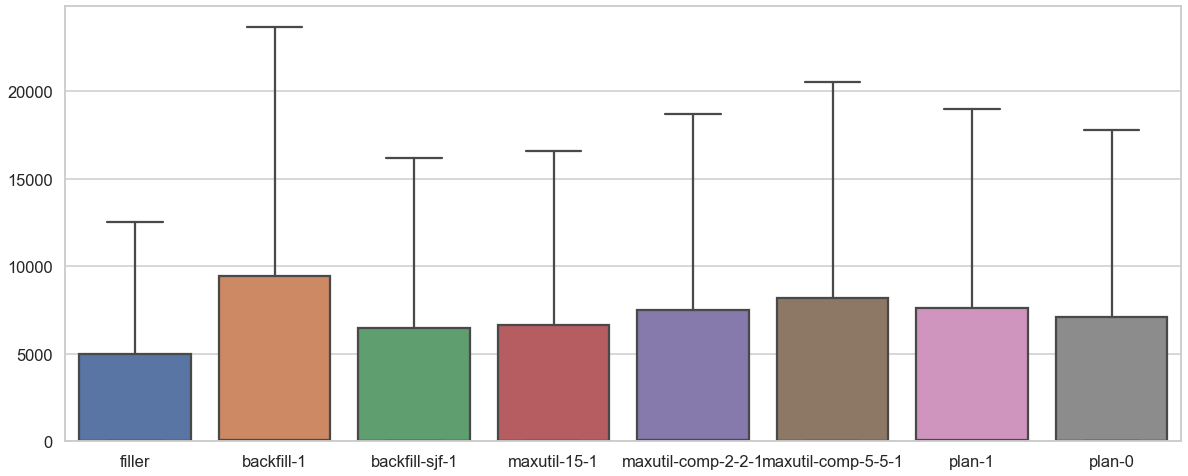

In [55]:
# Standard deviation
fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(data=waiting_times, showfliers=False, ax=ax)
ax.set_ylim(0)

In [56]:
turnaround_times = create_metric_df('turnaround_time')
turnaround_times.describe()

,filler,backfill-1,backfill-sjf-1,maxutil-15-1,maxutil-comp-2-2-1,maxutil-comp-5-5-1,plan-1,plan-0
count,2.845300e+04,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000,2.845300e+04
mean,3.004135e+04,23338.310470,22701.429423,22740.467772,22735.320625,22876.947853,24266.216346,3.323432e+04
std,1.523364e+05,47638.147605,49955.852757,50520.207526,49956.104741,48349.179457,55140.965655,3.853756e+05
min,9.040000e-02,0.166378,0.196674,0.090400,0.090400,0.194254,0.196674,9.040000e-02
25%,1.690134e+02,228.354229,127.322207,153.002312,197.001000,166.584817,131.550205,8.716033e+01
50%,5.318302e+03,6193.432889,4589.274884,4866.910273,5264.556236,5538.846716,4853.962635,3.830921e+03
75%,2.069844e+04,23883.842587,20597.501239,21214.988525,21668.167439,22656.616027,21201.963981,1.855133e+04
max,5.000808e+06,676610.196004,645513.341760,652295.042434,731670.309167,661071.669727,655262.491246,2.735350e+07


(0.0, 1000000.0)

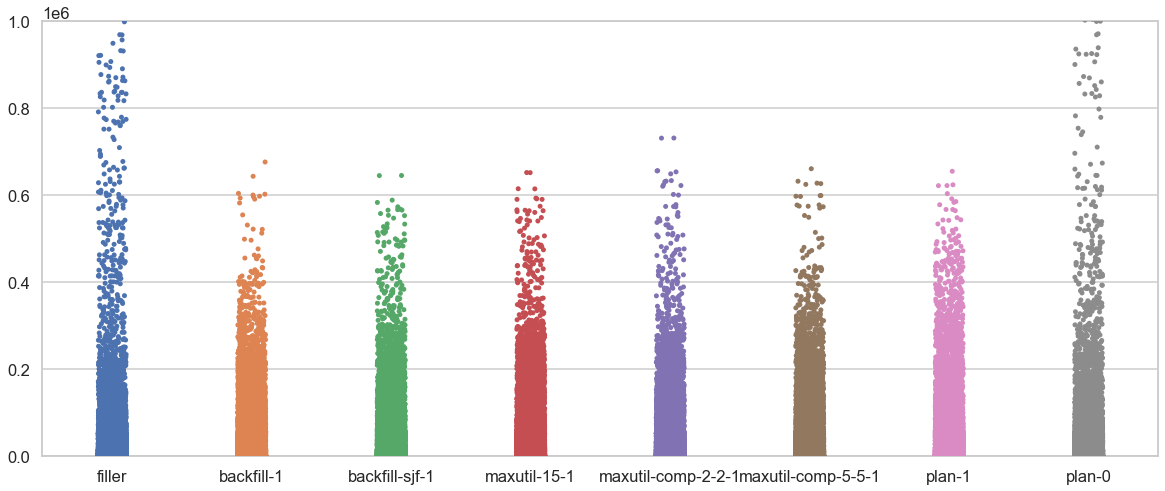

In [57]:
# Scatterplot, outliers
fig, ax = plt.subplots(figsize=(20,8))
sns.stripplot(data=turnaround_times, ax=ax)
ax.set_ylim(0,10**6)

<AxesSubplot:>

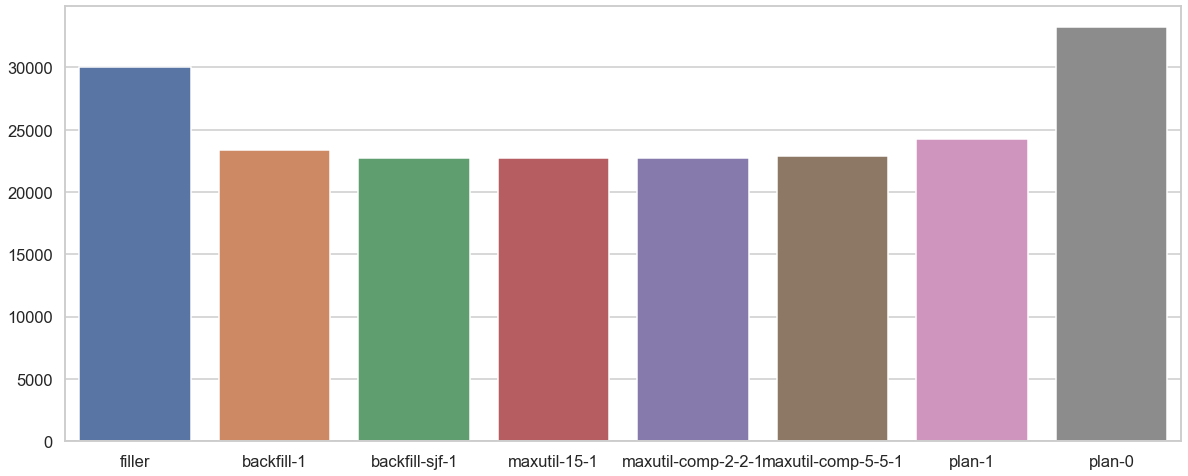

In [58]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data=turnaround_times, ci=None, ax=ax)

<AxesSubplot:>

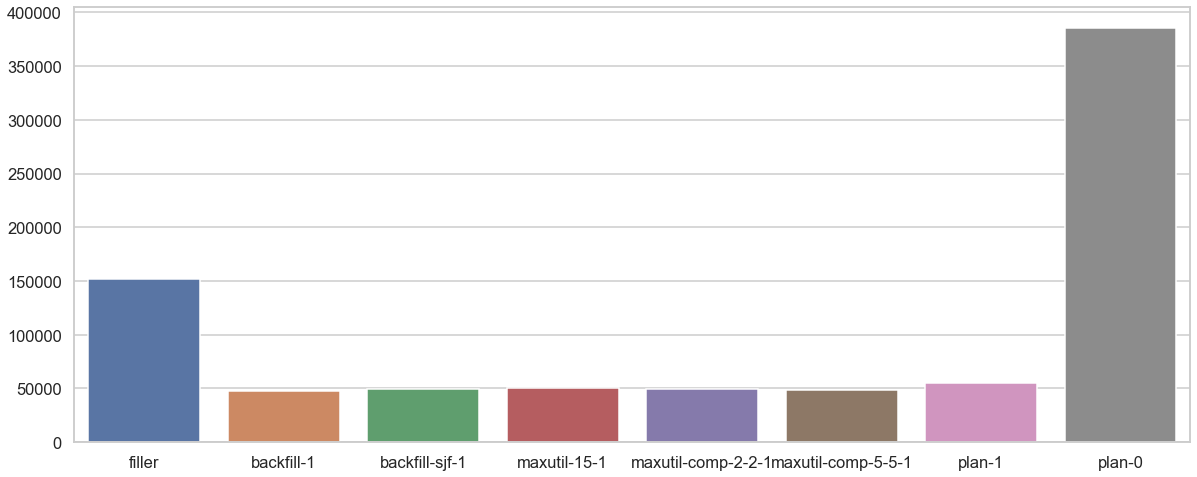

In [59]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data=turnaround_times, estimator=np.std, ci=None, ax=ax)

(0.0, 62333.32827354949)

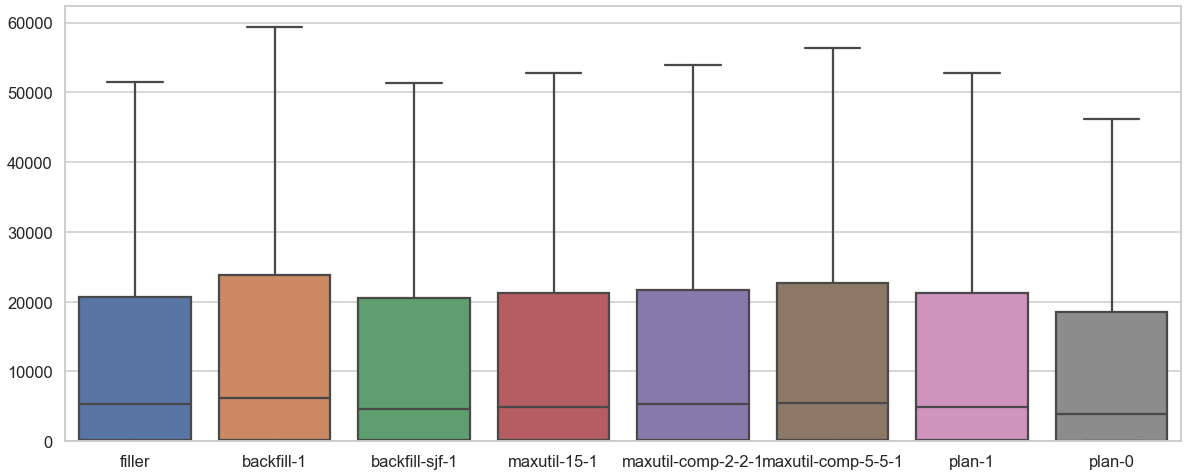

In [60]:
# Standard deviation
fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(data=turnaround_times, showfliers=False, ax=ax)
ax.set_ylim(0)

In [61]:
slowdown = create_metric_df('stretch')
slowdown.describe()

,filler,backfill-1,backfill-sjf-1,maxutil-15-1,maxutil-comp-2-2-1,maxutil-comp-5-5-1,plan-1,plan-0
count,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000
mean,180.639638,177.151205,129.122620,150.266699,150.532030,159.467506,141.954257,135.265010
std,1026.405021,1101.823154,951.051236,1356.411701,1193.556244,1112.942789,1198.556006,1958.631307
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.044776,1.000000,1.000002,1.025824,1.019603,1.040713,1.000000
75%,5.232060,7.975179,4.761832,5.323015,6.621179,6.223174,5.213821,3.459349
max,42459.521527,83237.330498,91699.288052,150157.134971,111099.868560,100610.486663,68408.619312,176397.123735


(0.0, 200000.0)

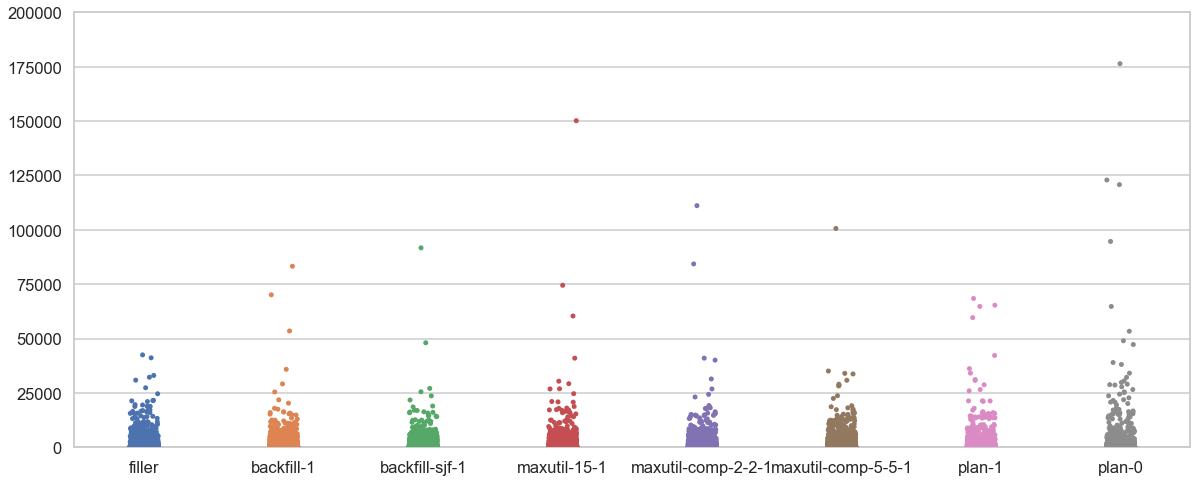

In [62]:
# Scatterplot, outliers
fig, ax = plt.subplots(figsize=(20,8))
sns.stripplot(data=slowdown, ax=ax)
ax.set_ylim(0, 0.2*10**6)

<AxesSubplot:>

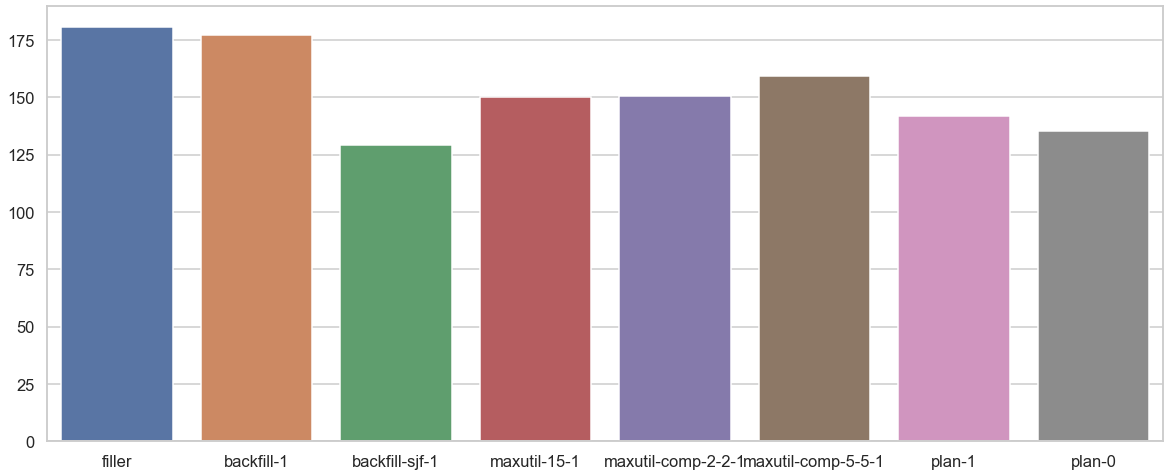

In [63]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data=slowdown, ci=None, ax=ax)

<AxesSubplot:>

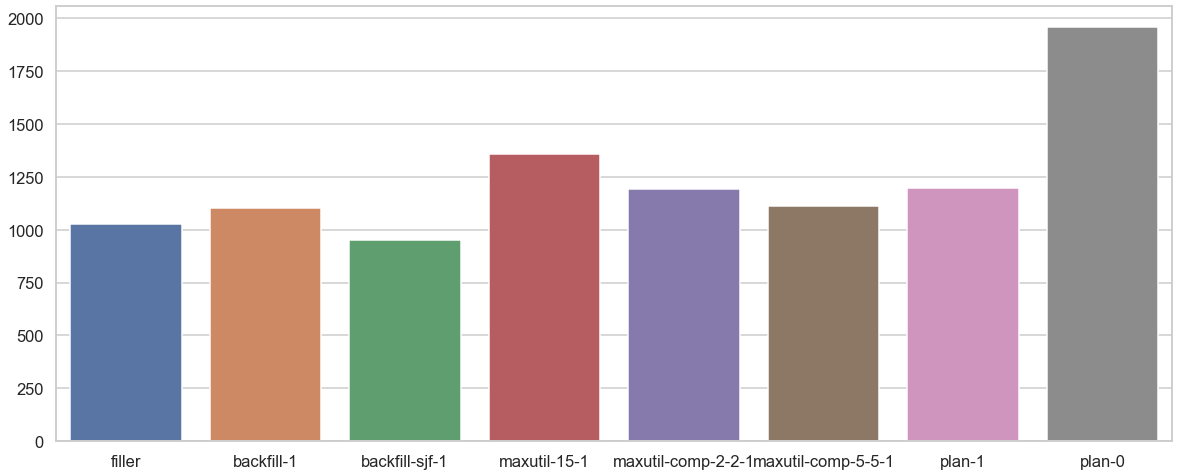

In [64]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data=slowdown, estimator=np.std, ci=None, ax=ax)

(0.0, 19.30930357314158)

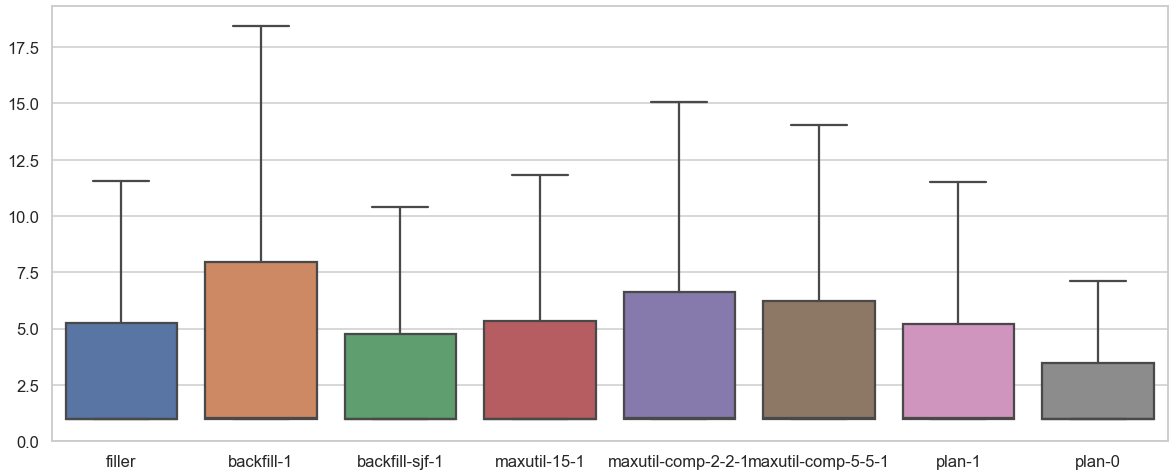

In [65]:
# Standard deviation
fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(data=slowdown, showfliers=False, ax=ax)
ax.set_ylim(0)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(0.0, 10000.0)

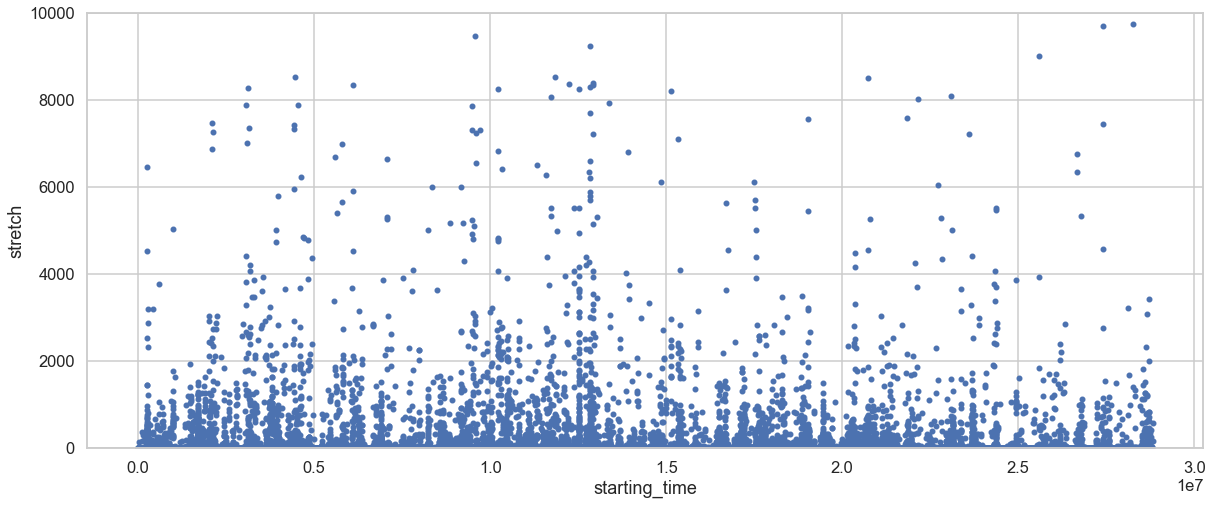

In [66]:
fig, ax = plt.subplots(figsize=(20,8))
# slowdown['maxutil-comp-2-2-1'].plot(ax=ax)
jobsets['maxutil-comp-2-2-1'].df[['starting_time', 'stretch']].plot(kind='scatter', x='starting_time', y='stretch', ax=ax)
ax.set_ylim(0,10000)

(0.0, 126813.51908449901)

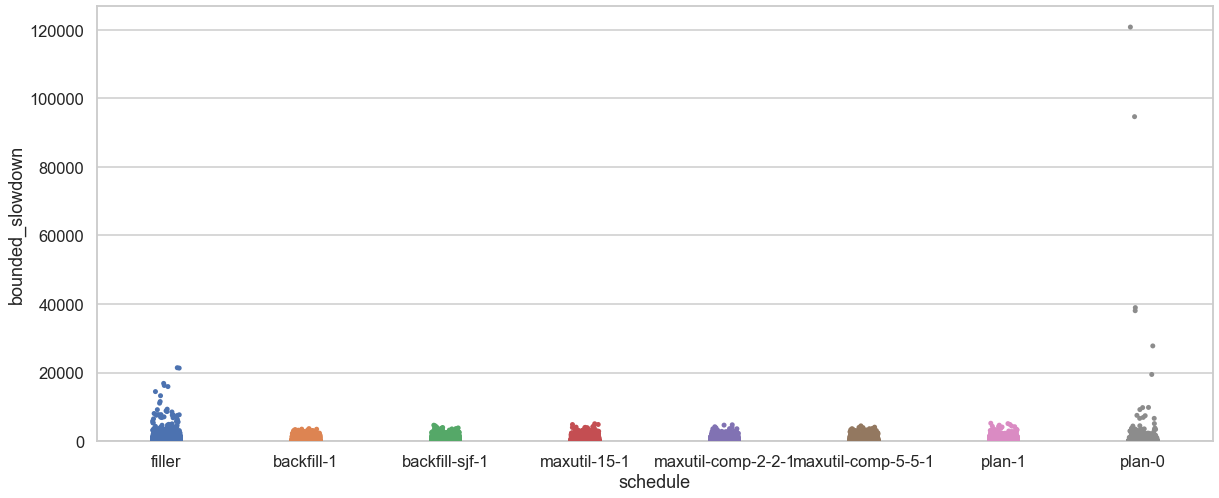

In [67]:
# Scatterplot, outliers
fig, ax = plt.subplots(figsize=(20,8))
sns.stripplot(data=metrics_df, x='schedule', y='bounded_slowdown', ax=ax)
ax.set_ylim(0)

<AxesSubplot:xlabel='schedule', ylabel='bounded_slowdown'>

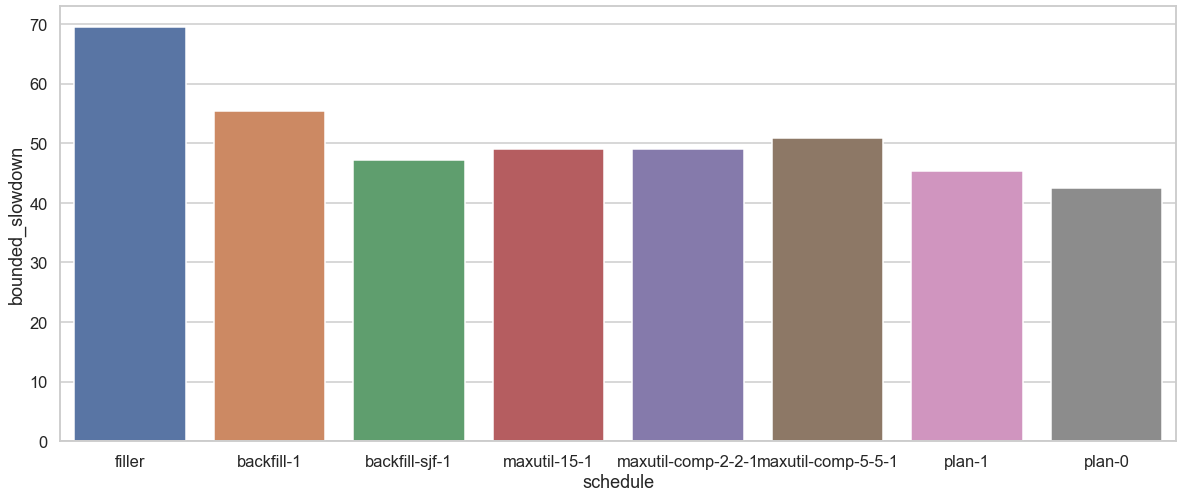

In [68]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data=metrics_df, x='schedule', y='bounded_slowdown', ci=None, ax=ax)

<AxesSubplot:xlabel='schedule', ylabel='bounded_slowdown'>

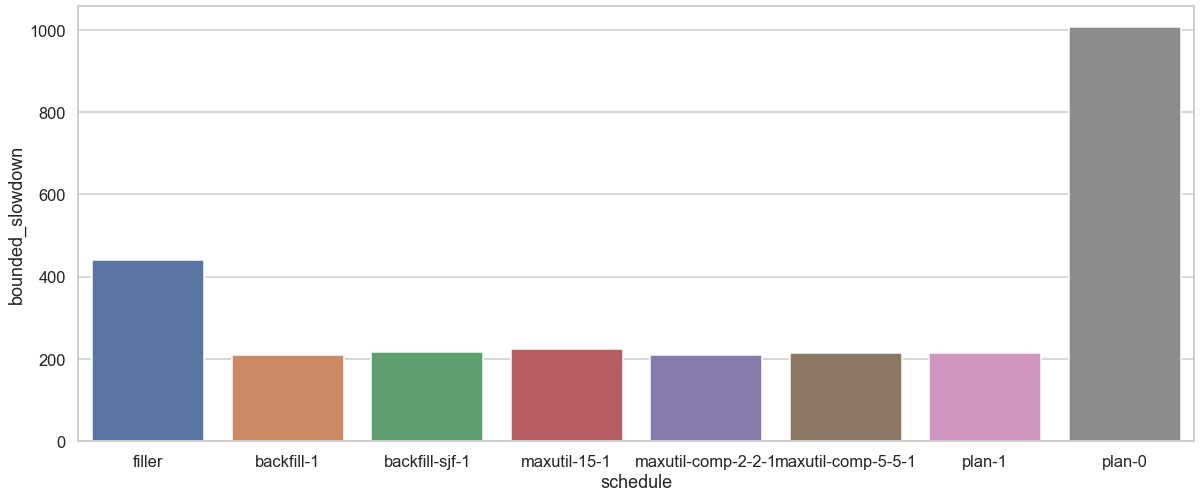

In [69]:
# Standard deviation
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data=metrics_df, x='schedule', y='bounded_slowdown', estimator=np.std, ci=None, ax=ax)

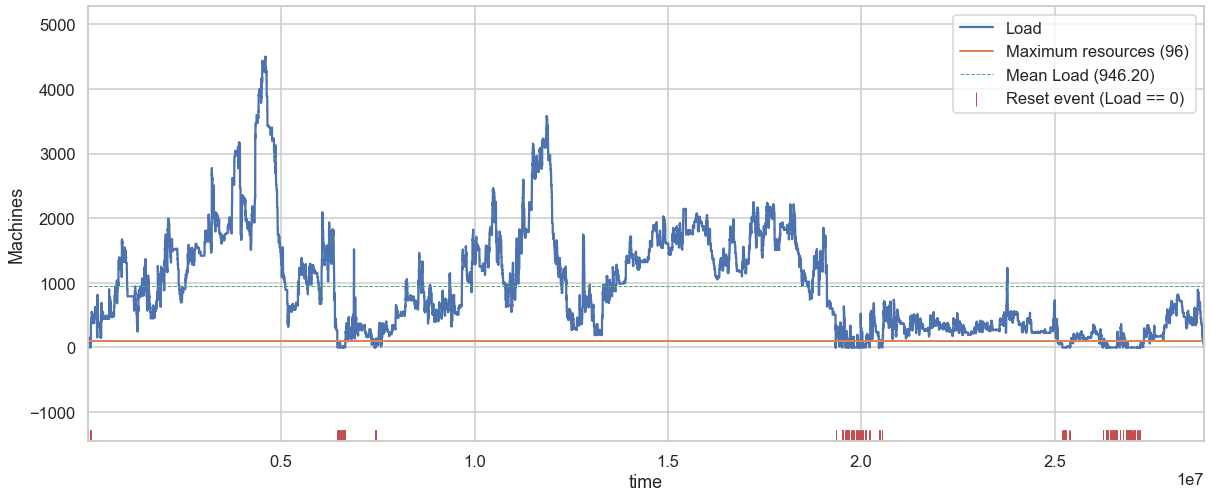

In [70]:
fig, ax = plt.subplots(figsize=(20,8))
visu.legacy.plot_load(jobsets['filler'].queue, nb_resources=96, ax=ax)

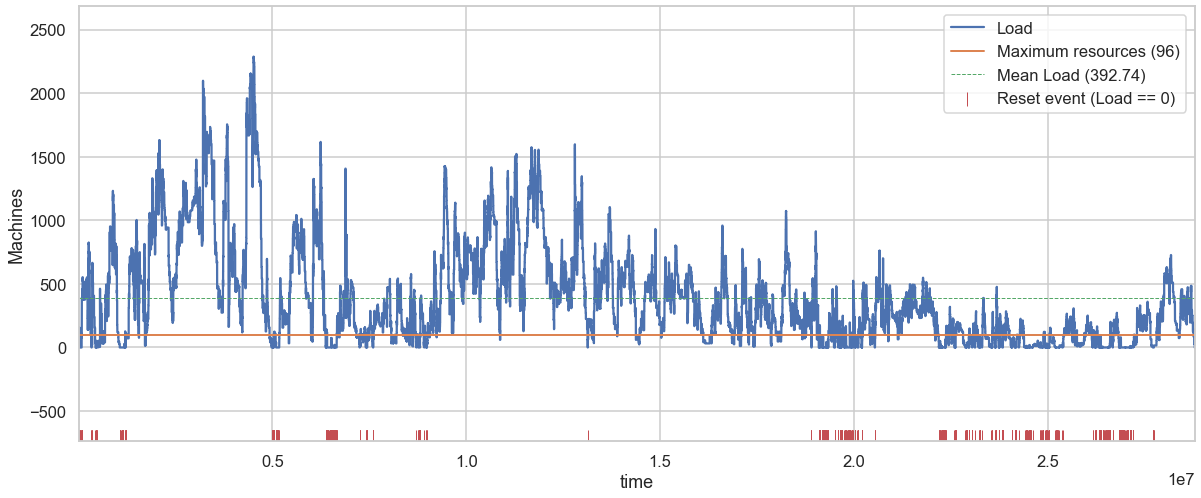

In [31]:
fig, ax = plt.subplots(figsize=(20,8))
visu.legacy.plot_load(jobsets['backfill-1'].queue, nb_resources=96, ax=ax)

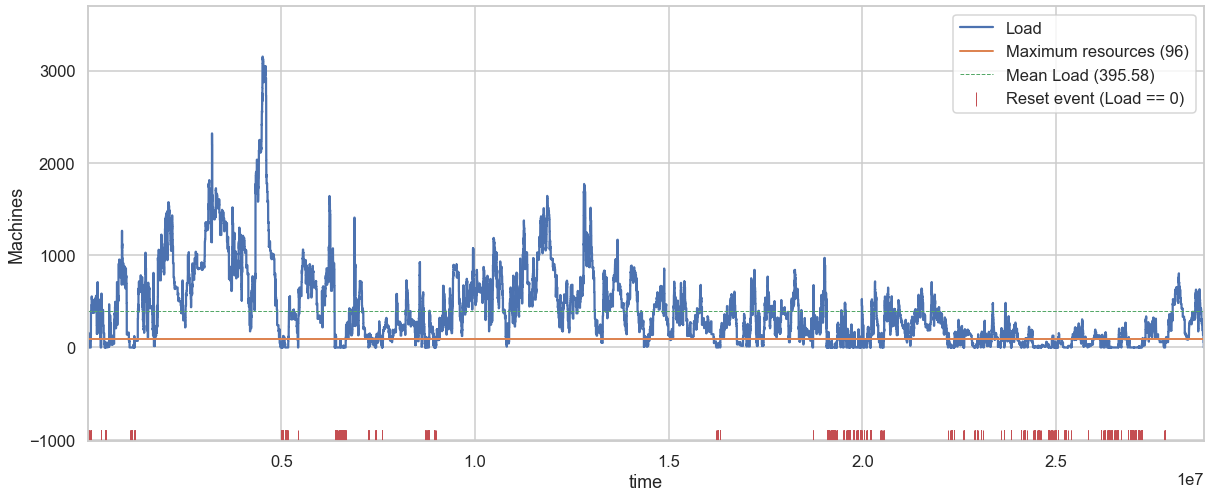

In [137]:
fig, ax = plt.subplots(figsize=(20,8))
visu.legacy.plot_load(jobsets['maxutil-comp-2-2-1'].queue, nb_resources=96, ax=ax)